In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

import swampy

xr.set_options(display_expand_data=False);

## Weighting coefficients

<xarray.DataArray 'c1' (lat: 720, lon: 1150)>
nan nan nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan nan
Coordinates:
  * lat      (lat) float64 23.0 23.04 23.08 23.11 ... 49.89 49.92 49.96 50.0
  * lon      (lon) float64 -125.0 -124.9 -124.9 -124.8 ... -65.1 -65.05 -65.0
Attributes:
    long_name:  Slope coefficient

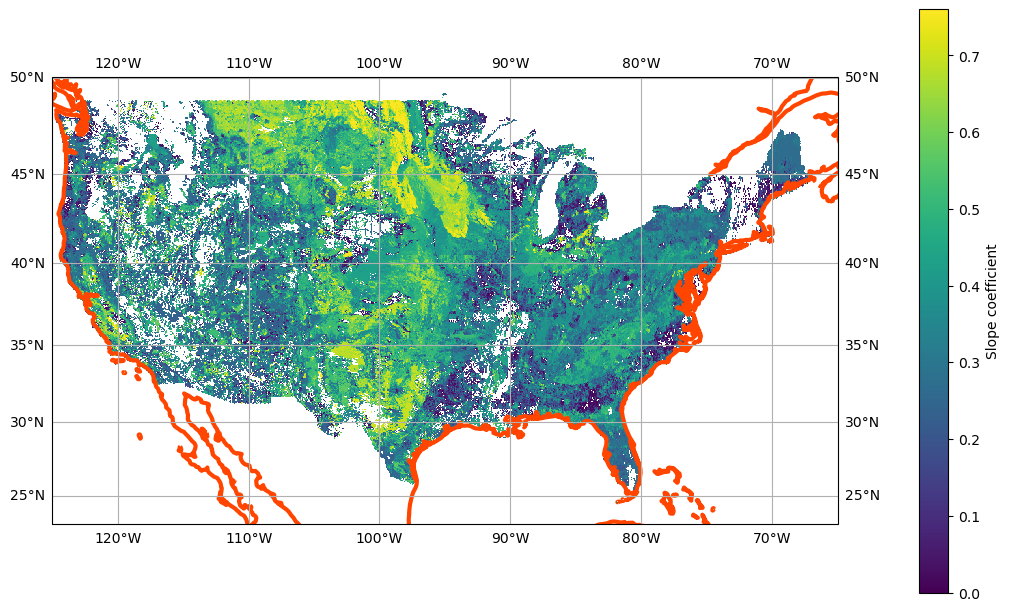

In [2]:
proj = ccrs.Mercator()
tran = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(10, 6), constrained_layout=True)
ax.coastlines(linewidth=3, color="orangered")
ax.gridlines(draw_labels=True)

C_ = swampy.C.c1.where(~(swampy.C.lon.isnull() | swampy.C.lat.isnull()), drop=True)
display(C_)

C_.plot(x="lon", y="lat", vmin=0, ax=ax, transform=tran);

## Run

In [3]:
%%time

# NOTE: 2022 day 215 (08/03) is missing, as are other random days
# NOTE: Running days where the ALEXI ET file is unavailable in
# https://geo.nsstc.nasa.gov/SPoRT/outgoing/crh/4ecostress/
# currently requires that the file is available in your cache.
# The script `scripts/alexi-et-missing.py` checks which days in current year are available.
start = "2022/04/01"
end = "2022/04/15"
ic = None

ds = swampy.run(start, end, ic=ic)

loading PRISM P
loading ALEXI ET
computing P - ET
computing SM
CPU times: total: 3.28 s
Wall time: 6.65 s


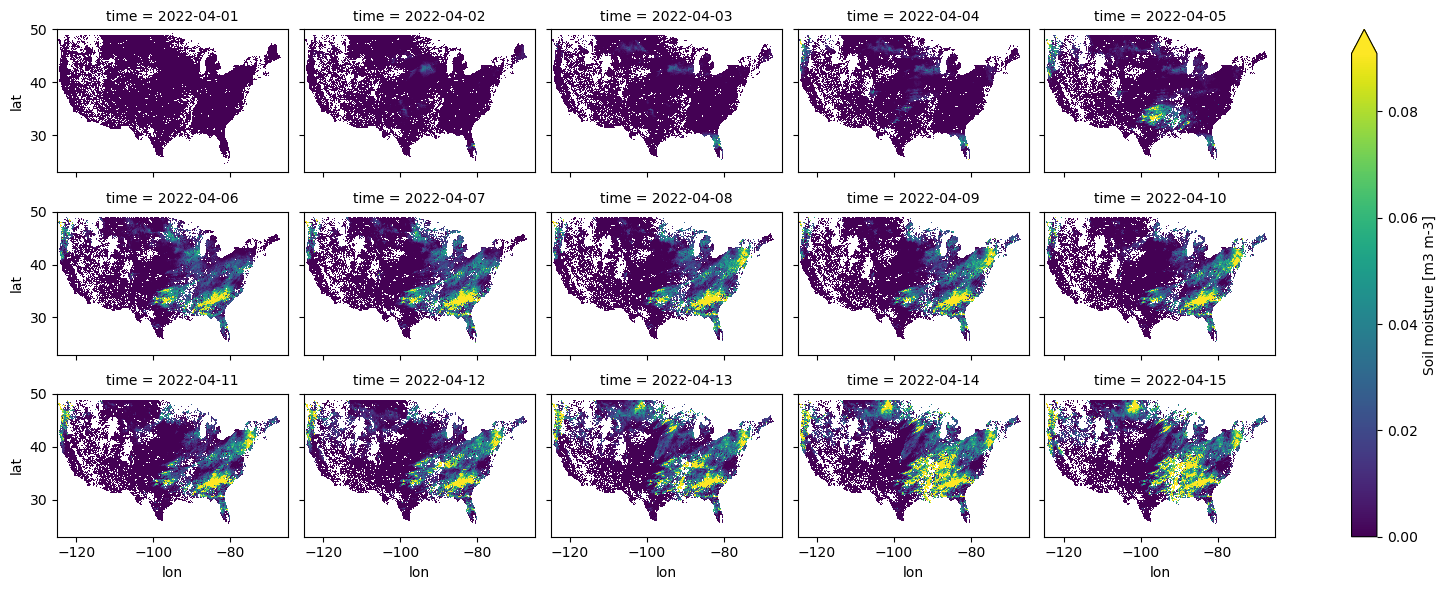

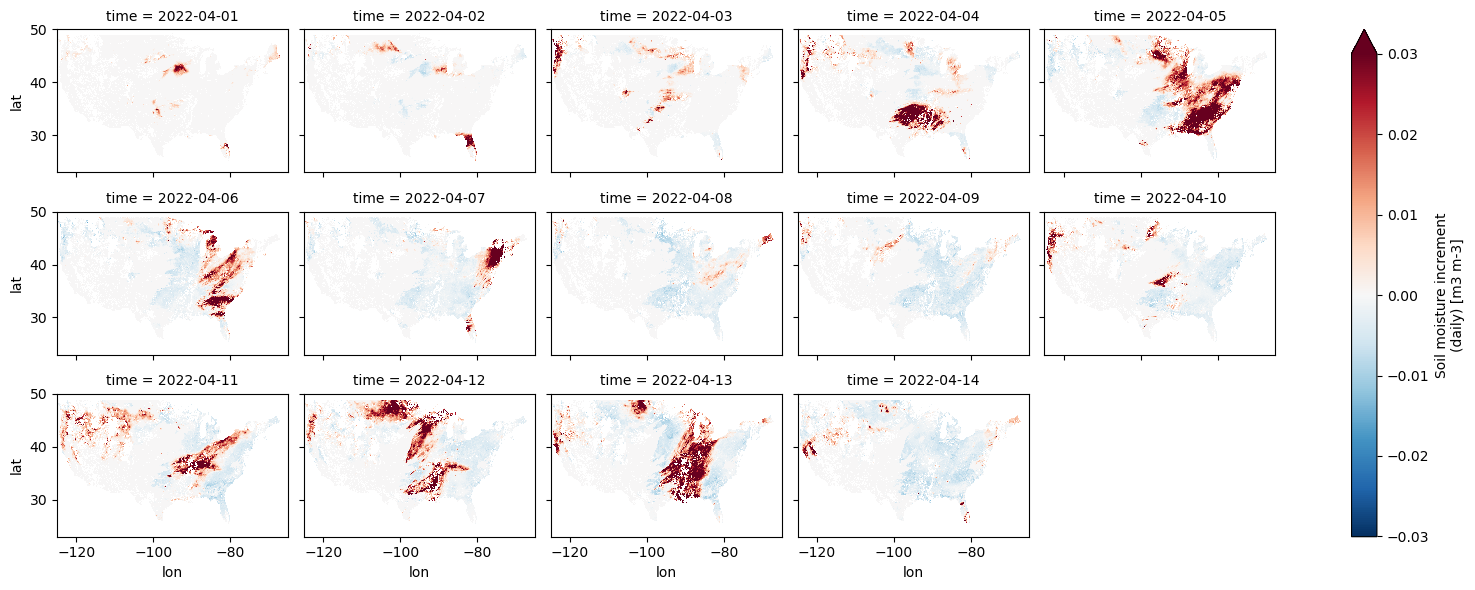

In [4]:
# Plot results
ds.sm.plot(col="time", col_wrap=5, robust=True, size=2, aspect=1.5)

# Plot deltas
with xr.set_options(keep_attrs=True):
    dsm = ds.sm.diff("time", label="lower")
    dsm.attrs.update(long_name="Soil moisture increment (daily)")
    dsm.plot(col="time", col_wrap=5, robust=True, size=2, aspect=1.5)

## Options

In [5]:
%%time

ics = ["zero", "crn", "awc"]

cases = [
    dict(ic=ic)
    for ic in ics
]

ds = xr.concat(
    [
        swampy.run(start, end, **case, quiet=True)
        for case in cases
    ],
    dim="case",
)

CPU times: total: 14.6 s
Wall time: 1min 2s


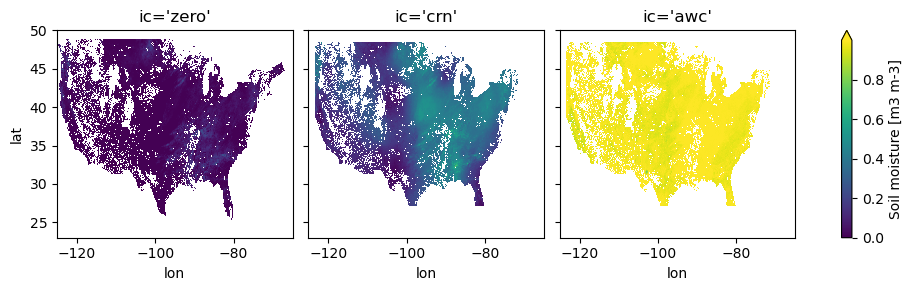

In [6]:
fg = ds.sm.isel(time=-1).plot(col="case", col_wrap=3, robust=True)

for case, ax in zip(cases, fg.axs.flat):
    s_case = ", ".join(f"{k}={v!r}" for k, v in case.items())
    ax.set_title(s_case)